In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fortecubeview

# Water: Learning how to use Psi4 and iterating over basis sets
Alright first example. Calculate the minimized energy for water using a couple of basis sets. The first block sets up the input geometry for the molecule. 

In [2]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

Next, let's check out the initial conditions, then run an optimization and print the geometry and energy again. We need to tell Psi4 a theory and a basis set, which can be given by a string of the form `typeOfTheory/BasisSet`

 Exhaustive list of basis sets is here: https://psicode.org/psi4manual/master/basissets_tables.html#apdx-basistables
 List of modules is here: https://psicode.org/psi4manual/master/autodoc_options_c_bymodule.html#apdx-options-c-module

In [3]:
print("Initial geometry is\n", np.array(h2o.geometry()))
print("Initial energy is ", psi4.energy('scf/STO-3g'))
psi4.optimize('scf/STO-3g', molecule = h2o)
print("Final geometry is\n", np.array(h2o.geometry()))
print("Final energy is ", psi4.energy('scf/STO-3g'))

Initial geometry is
 [[ 0.          0.         -0.12429781]
 [ 0.         -1.43441927  0.98634825]
 [ 0.          1.43441927  0.98634825]]
Initial energy is  -74.96340594386216
Optimizer: Optimization complete!
Final geometry is
 [[ 0.          0.         -0.13454743]
 [ 0.         -1.43235828  1.0676827 ]
 [ 0.          1.43235828  1.0676827 ]]
Final energy is  -74.96599000640173


There's a lot of information about the molecule folded in to the psi4 object. Here are a couple of examples. 

In [18]:
print("Point group is ", h2o.get_full_point_group())
print("y position of atom 2 is ", h2o.fy(2))
h2o_geometry = np.array(h2o.geometry()) #grab the geometry and store it
bond_length = np.linalg.norm(h2o_geometry[1,:]-h2o_geometry[0,:])*0.529177 #calculate the distance then convert from Bohr to Angstroms
print("H-O bond length is ", bond_length, " Angstroms")

Point group is  C2v
y position of atom 2 is  1.432857772251163
H-O bond length is  0.9894129791175227  Angstroms


Next, let's iterate over a couple of basis sets, to see how the energy changes with increasing complexity. In this case, I'm setting the basis set in one line as an option, then running the energy calculation with the selected theory.

Psi4Education basis_sets lab has a lot more information about choosing a basis set, why we use gaussian basis sets, and what all the various types mean.

In [19]:
basis_sets = ["STO-3G", "3-21G", "6-31G", "cc-pvdz"]
for basis_set in basis_sets: 
    print(basis_set)
    psi4.set_options({'basis': basis_set})
    result, wfn = psi4.energy('scf', return_wfn = True)
    print("Energy is ", result)
    print("Number of basis sets is ", wfn.basisset().nbf())

STO-3G
Energy is  -74.96599008714523
Number of basis sets is  7
3-21G
Energy is  -75.58362842334307
Number of basis sets is  13
6-31G
Energy is  -75.97974653727381
Number of basis sets is  13
cc-pvdz
Energy is  -76.02310428323219
Number of basis sets is  24


# H2: Generating a PE diagram by iterating over geometry

This is an example from the folks at Chem Compute, and it makes me so happy. We're gonna start by setting up an array of bond lengths. The resolution is higher at shorter bond lengths, so we start by making several small arrays at different resolutions and then stick them together.

In [20]:
short = np.arange(0.2,1.0,0.02)
medium = np.arange(1.0,3.0,0.25)
long = np.arange(3.0,10.0,1.0)

Rvals = np.concatenate([short,medium,long])
print (Rvals)

[0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46
 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74
 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.25
 1.5  1.75 2.   2.25 2.5  2.75 3.   4.   5.   6.   7.   8.   9.  ]


Now that we've got the array of bond lengths, let's calculate the energy of an H2 molecule at each of those bond lengths. First, we set up a couple of arrays to hold things.

Next, there's a nifty `for` loop that uses a new kind of string variables I just learned. It makes a set strings in the format of input files, with the bond length being each of the values in our bonnd length array. For each bond length, we calculate the energy, and collect the outputted bond length and energy in an array to hold on to.


In [21]:
arrayForBondLengths = []
arrayForEnergies = []

for R in Rvals:
    geometry = f"""
    H 0 0 0
    H 0 0 {R}
    """
    
    h2 = psi4.geometry(geometry)
    E = psi4.energy('scf/sto-3g',molecule=h2)
    arrayForBondLengths.append(R)
    arrayForEnergies.append(E)
    print (R,E)


0.2 0.16412595411337005
0.22 -0.053077207700557016
0.24 -0.2292559285483332
0.26 -0.37387524173823816
0.27999999999999997 -0.4937357845183453
0.29999999999999993 -0.5938530072209464
0.31999999999999995 -0.6780072547351106
0.33999999999999997 -0.7491005851222121
0.35999999999999993 -0.8093956866658003
0.3799999999999999 -0.860680413644414
0.3999999999999999 -0.9043839611955838
0.41999999999999993 -0.9416607190272752
0.4399999999999999 -0.973451967558839
0.4599999999999999 -1.000532022593286
0.47999999999999987 -1.0235432262695676
0.49999999999999983 -1.0430227794889946
0.5199999999999998 -1.0594235013753739
0.5399999999999998 -1.0731299997950743
0.5599999999999998 -1.0844713316497
0.5799999999999998 -1.093730953263734
0.5999999999999999 -1.1011545659749622
0.6199999999999999 -1.1069563219781506
0.6399999999999998 -1.1113237524575994
0.6599999999999997 -1.1144217022973475
0.6799999999999997 -1.1163954955110555
0.6999999999999997 -1.1173735079951523
0.7199999999999998 -1.1174692860182558



This output is ugly and confusing to read. Let's plot it instead!

<IPython.core.display.Javascript object>


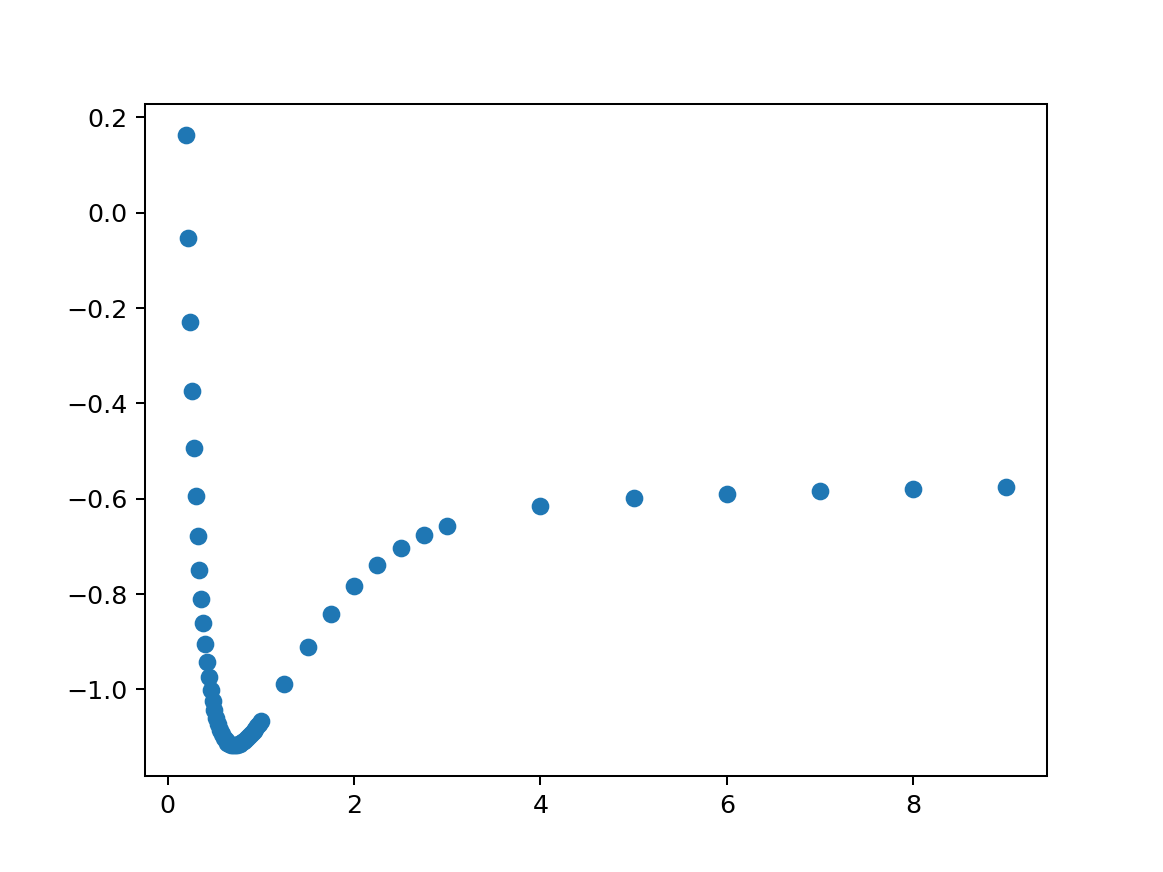

In [22]:
%matplotlib notebook

plt.scatter(arrayForBondLengths,arrayForEnergies)

# Description of a Z-matrix

Notes for myself because I'm struggling to remember.
 - Each line is one atom
 - The first atom is just identified
 - Next atom gets it's symbol and a bond length relative to #1
 - Next atom gets symbol, bond length, bond angle
 - Next atom gets symbol, bond length, bond angle, dihedral
 - Each row references previously defined atoms by number, 1-indexed

# Methane

Playing a bit with methane here, to explore how to input things a little differently. FIrstly, let's try inputing the wrong bond length and then optimizing the geometry to get the real length.

In [23]:
r = 2
ch4 = psi4.geometry(f"""
C
H 1 {r}
H 1 {r} 2 109.5
H 1 {r} 2 109.5 3 120
H 1 {r} 2 109.5 3 -120
""")

In [24]:
methaneEnergy = psi4.energy("scf/STO-3G", molecule = ch4)
print("The minized energy at this bond length is ", methaneEnergy)

The minized energy at this bond length is  -38.847253569085744


In [25]:
methaneEnergy_opt = psi4.optimize('scf/sto-3g',molecule = ch4)
print("The minized energy at this bond length is ", methaneEnergy_opt)

Optimizer: Optimization complete!
The minized energy at this bond length is  -39.72701070937292


## Back to water

I'm working with the previously defined water geometry from way up top.

First, I'm going to optimize the geometry.

The next line performes the frequency analysis. This saves a *lot* of information in a funny pile of data types.

Information on working out frequencies is here:
https://psicode.org/psi4manual/master/freq.html#psi4.frequency

Useful example showing all of these functions
https://github.com/psi4/psi4/blob/master/samples/fd-freq-gradient/input.dat


In [4]:
psi4.optimize('scf/6-31g',molecule = h2o)
e, wfn = psi4.frequencies('scf/6-31g', molecule = h2o, return_wfn = True)
vibinfo = wfn.frequency_analysis

Optimizer: Optimization complete!


The next two cells are me pulling out some useful information from the generated vibrational information and outputting it as a nice table.

In [5]:
reps = vibinfo['gamma'].data
freqs = np.real(vibinfo['omega'].data)
motion = vibinfo['TRV'].data
deg = vibinfo['degeneracy'].data

In [29]:
pd.DataFrame(np.transpose([reps, freqs, motion, deg]), columns = ["Representation", "Frequency", "Type of motion", "Degeneracy"])

,Representation,Frequency,Type of motion,Degeneracy
0,None,0.000000,TR,6
1,None,0.000000,TR,6
2,None,0.000000,TR,6
3,None,0.000000,TR,6
4,None,0.000000,TR,6
5,None,0.000031,TR,6
6,A1,1737.052391,V,1
7,A1,3988.641527,V,1
8,B2,4145.574061,V,1


It's the right symmetry, and the normal modes are just fine. Below, I'm testing how robust it is to putting in a goofy initial geometry - I stretched one of the bonds out. Looks like it still settles on the frequencies pretty well, but flubs the representations.

In [31]:
h2o = psi4.geometry("""
O
H 1 1.2
H 1 2.2 2 104.5
""")

psi4.optimize('scf/6-31g',molecule = h2o)
e, wfn = psi4.frequencies('scf/6-31g', molecule = h2o, return_wfn = True)
vibinfo = wfn.frequency_analysis

reps = vibinfo['gamma'].data
freqs = np.real(vibinfo['omega'].data)
motion = vibinfo['TRV'].data
deg = vibinfo['degeneracy'].data

pd.DataFrame(np.transpose([reps, freqs, motion, deg]), columns = ["Representation", "Frequency", "Type of motion", "Degeneracy"])

Optimizer: Optimization complete!


,Representation,Frequency,Type of motion,Degeneracy
0,None,0.000000,TR,6
1,None,0.000000,TR,6
2,None,0.000000,TR,6
3,None,0.000000,TR,6
4,None,0.000020,TR,6
5,None,0.000027,TR,6
6,Ap,1737.018322,V,1
7,Ap,3989.062961,V,1
8,Ap,4145.976961,V,1


# Visualizing surfaces and normal modes

## fortecubeview

Playing around here with 'fortecubeview'. Github repo is here: https://github.com/evangelistalab/fortecubeview/blob/master/examples/psi4/example.ipynb
Talk from PsiCon2020 is here:
https://www.youtube.com/watch?v=ItNdmODVgp0

The first line below creates a bunch of cube files from a set of wave functions. `.cube` files are Gaussian style output files that records a surface on an xyz grid. It takes ages to write and then read all the cube files (that's a lot of data) so using the options to set which orbitals you want is a good idea. Getting the viewer to open takes a beat. Once it's there, you can select a surface, rotate it, and zoom it.

In [6]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

h2o_geometry = np.array(h2o.geometry()) #grab the geometry and store it
bond_length = np.linalg.norm(h2o_geometry[1,:]-h2o_geometry[0,:])*0.529177 #calculate the distance then convert from Bohr to Angstroms
print("initial bond length is ", bond_length)

#set it to write the normal modes information to a data file and set the filename
psi4.set_options({"normal_modes_write": True})
psi4.set_options({"writer_file_label":"water"})

#calculate the normal modes
psi4.optimize('scf/6-31g',molecule = h2o)
e, wfn = psi4.frequencies('scf/6-31g', molecule = h2o, return_wfn = True)
vibinfo = wfn.frequency_analysis

#some output information to make sure I haven't messed anything up
print("The frequencies we're looking at are", np.array(wfn.frequencies()))
h2o_geometry = np.array(h2o.geometry()) #grab the geometry and store it
bond_length = np.linalg.norm(h2o_geometry[1,:]-h2o_geometry[0,:])*0.529177 
print("H-O bond length is ", bond_length, " Angstroms")

initial bond length is  0.9599996178157412
Optimizer: Optimization complete!
The frequencies we're looking at are [1737.0839084  3988.31040596 4145.25497077]
H-O bond length is  0.9496362492029669  Angstroms


In [7]:
psi4.set_options({
    'CUBEPROP_TASKS': ['ORBITALS','DENSITY'],
    'CUBEPROP_ORBITALS': [5,6],
})

psi4.cubeprop(wfn) #writes the cube files

fortecubeview.plot(width=500,height=300,colorscheme='emory',sumlevel=0.75) #launches the viewer

CubeViewer: listing cube files from the directory .
Reading 22 cube files


/opt/conda/lib/python3.8/site-packages/fortecubeview/py3js_renderer.py:1096: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  values = skimage.measure.marching_cubes_lewiner(data, level * 0.995)
/opt/conda/lib/python3.8/site-packages/fortecubeview/cube_file.py:213: RuntimeWarning: invalid value encountered in double_scalars
  if partial_sum / sum < fraction:


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('Density (alpha)', 'Density (beta)', 'Density…

For reasons I don't get yet, it's adding in a number in the output file name. Look in the directory you're working it to find the file with the suffix `molden_normal_modes` and put it's name in the line below. Give it a beat to open the viewer.

In [57]:
fortecubeview.vib('water.30.molden_normal_modes')

HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Select:', options=('1: Normal mode (1737.1 cm^-1)', '2: Normal mode …

### now let's repeat with benzene, just to practice

Also, notice how I'm pulling the geometry from pubchem :-) I'm gonna show the normal modes first, then I'm gonna spit out some cube files, read them back in, and show orbitals.

In [58]:
benzene = psi4.geometry(f"""
pubchem:benzene
""")
psi4.set_options({"normal_modes_write": True})
psi4.set_options({"writer_file_label":"benzene"})

psi4.optimize('scf/STO-3g', molecule = benzene)
e, wfn = psi4.frequencies('scf/STO-3g', molecule = benzene, return_wfn = True)



	Searching PubChem database for benzene (single best match returned)
	Found 1 result(s)
Optimizer: Optimization complete!


In [8]:
fortecubeview.vib('benzene.30.molden_normal_modes')

HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Select:', options=('1: Normal mode (478.1 cm^-1)', '2: Normal mode (…

In [61]:
psi4.set_options({
    'CUBEPROP_TASKS': ['ORBITALS'],
    'CUBEPROP_ORBITALS': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
})
psi4.cubeprop(wfn)
fortecubeview.plot(width=500,height=300,colorscheme='emory',sumlevel=0.75)

CubeViewer: listing cube files from the directory .
Reading 22 cube files


/opt/conda/lib/python3.8/site-packages/fortecubeview/py3js_renderer.py:1096: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  values = skimage.measure.marching_cubes_lewiner(data, level * 0.995)
/opt/conda/lib/python3.8/site-packages/fortecubeview/cube_file.py:213: RuntimeWarning: invalid value encountered in double_scalars
  if partial_sum / sum < fraction:


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('Density (alpha)', 'Density (beta)', 'Density…

Notice that it loads ALL the cube files in the directory. Since I did some water cube files up above, those got loaded in here with benzene. It'd be smart to be aggressive with directory control when working with this.

## Using nbjsmol viewer

In [64]:
from nbjsmol import nbjsmol_display

psi4.molden(wfn, 'benzene.molden')

nbjsmol_display('benzene.molden')

This line outputs a Molden file: `psi4.molden(wfn,'ethane.molden')`
These lines display the molecule: `from nbjsmol import nbjsmol_display
nbjsmol_display ('ethane.molden')`
Taken from Psi4Numpy experiment 03a. This viewer lets you see numerical bond lengths and angles by clicking on the atoms.

# My attempt to summarize the Psi4 workflow

1. Create the geometry of your molecule. This is a string of that funny format that I'm still learning. You can save this as a string (which you can then use to iterate over several values) or you can input it directly.
2. `moleculeName = psi4.geometry(yourGeometryStringGoesHere)` is the call for creating a molecule with a set geometry. You can access the geometry with `np.array(h2o.geometry())`
3. To perform an energy calculation on the current geometry, the call is `outputEnergy = psi4.energy('theory/basisSet', molecule=moleculeName)`
4. If you don't specify the molecule, it'll assume the most recent set geometry
5. You can set the basis set (and probably lots of other options) directly: `psi4.set_options({'basis': basis_set})`
6. To optimize the geometry, run `psi4.optimize('theory/basisSet', molecule=moleculeName)`
7. To calculate normal modes and have the output available to explore:
`e, wfn = psi4.frequencies('theory/basisSet', molecule=moleculeName, return_wfn = True)

8. You can then shove the vibrational information into an object: `vibinfo = wfn.frequency_analysis`. This object is a dictionary described in https://psicode.org/psi4manual/master/freq.html#psi4.frequency. I found it easiest to pull out just a few dictionary items for display.
9. You can view the molecule using nbjsmol and get calculated geometry information. It can also display surfaces.
10. You can use fortecubeviewer to see surfaces as well as view the motions involved in normal modes.

The MolSSI Quantum Mechanics Tools tutorial is really good:
https://education.molssi.org/qm-tools/
I've looked through lessons 1 and 4 to put together a lot of these notes. I've skimmed 2 and 3.